In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Step 1: Load and resize images
def load_images(max_size=1000):
    """Load, resize, and validate four overlapping images."""
    paths = [
        r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_c\im1.jpg',
        r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_c\im2.jpg',
        r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_c\im3.jpg',
        r'D:\University\Computer_vision\CV\Computer_vision_assigment\Midterm\data\input\part_c\im4.jpg'
    ]
    images = []
    for path in paths:
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        # Resize image to keep max dimension <= max_size
        h, w = img.shape[:2]
        scale = min(max_size / w, max_size / h, 1.0)
        if scale < 1.0:
            img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        images.append(img)
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    
    # Visualize input images
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images, 1):
        plt.subplot(2, 2, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Image {i}')
        plt.axis('off')
    plt.suptitle('Input Images')
    plt.tight_layout()
    plt.savefig('input_images.png')
    plt.show()
    
    return images, gray_images

In [18]:
# Step 2: SIFT feature detection
def detect_sift_features(gray_images, contrast_threshold=0.04, edge_threshold=10):
    """Detect SIFT keypoints and descriptors."""
    sift = cv2.SIFT_create(contrastThreshold=contrast_threshold, edgeThreshold=edge_threshold)
    keypoints_list, descriptors_list, keypoints_images = [], [], []
    for i, gray_img in enumerate(gray_images):
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
        keypoint_img = cv2.drawKeypoints(
            gray_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        keypoints_images.append(keypoint_img)
        print(f"Image {i+1}: Detected {len(keypoints)} keypoints")
    
    # Visualize keypoints
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(keypoints_images, 1):
        plt.subplot(2, 2, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Image {i} Keypoints')
        plt.axis('off')
    plt.suptitle('SIFT Keypoints')
    plt.tight_layout()
    plt.savefig('sift_keypoints.png')
    plt.show()
    
    return keypoints_list, descriptors_list

In [19]:
# Step 3: Feature matching
def match_features(keypoints_list, descriptors_list, ratio_threshold=0.75):
    """Match SIFT keypoints between consecutive image pairs."""
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_list = []
    for i in range(len(descriptors_list) - 1):
        matches = matcher.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)
        good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
        matches_list.append(good_matches)
        print(f"Image {i+1} to Image {i+2}: {len(good_matches)} good matches")
    
    # Visualize matches
    plt.figure(figsize=(15, 10))
    for i in range(len(matches_list)):
        match_img = cv2.drawMatches(
            images[i], keypoints_list[i],
            images[i + 1], keypoints_list[i + 1],
            matches_list[i], None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.subplot(len(matches_list), 1, i + 1)
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Matches: Image {i+1} to Image {i+2}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('matched_keypoints.png')
    plt.show()
    
    return matches_list

In [20]:
# Step 4: Homography estimation
def estimate_homography(keypoints_list, matches_list, ransac_reproj_threshold=5.0):
    """Estimate homography matrices between consecutive image pairs."""
    homographies = []
    inlier_masks = []
    for i, matches in enumerate(matches_list):
        src_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_reproj_threshold)
        if H is None:
            print(f"Image {i+1} to Image {i+2}: Homography estimation failed.")
            homographies.append(None)
            inlier_masks.append(None)
        else:
            inliers = np.sum(mask)
            print(f"Image {i+1} to Image {i+2}: {inliers} inliers out of {len(matches)} matches")
            homographies.append(H)
            inlier_masks.append(mask.ravel().tolist())
    
    # Visualize inlier matches
    plt.figure(figsize=(15, 10))
    for i in range(len(matches_list)):
        inlier_matches = [m for j, m in enumerate(matches_list[i]) if inlier_masks[i] and inlier_masks[i][j]]
        match_img = cv2.drawMatches(
            images[i], keypoints_list[i],
            images[i + 1], keypoints_list[i + 1],
            inlier_matches, None,
            matchColor=(0, 255, 0),
            singlePointColor=None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.subplot(len(matches_list), 1, i + 1)
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Inlier Matches: Image {i+1} to Image {i+2}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('inlier_matches.png')
    plt.show()
    
    return homographies, inlier_masks

In [21]:
# Step 5: Warping and blending
def warp_and_blend_images(images, homographies, reference_idx=1, max_canvas_size=10000):
    """Warp images using homographies and blend them into a panorama with canvas size limit."""
    h, w = images[reference_idx].shape[:2]
    corners = []
    for i in range(len(images)):
        H = np.eye(3)
        if i < reference_idx:
            for j in range(i, reference_idx):
                H = np.dot(homographies[j], H)
        elif i > reference_idx:
            for j in range(reference_idx, i):
                H = np.dot(np.linalg.inv(homographies[j]), H)
        corners_i = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners_i, H)
        corners.append(warped_corners)
    
    # Compute canvas size with limits
    all_corners = np.concatenate(corners, axis=0)
    x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
    panorama_width = min(x_max - x_min, max_canvas_size)
    panorama_height = min(y_max - y_min, max_canvas_size)
    
    # Adjust translation to fit within canvas
    translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    
    # Scale homographies if canvas exceeds max size
    scale = min(max_canvas_size / panorama_width, max_canvas_size / panorama_height, 1.0)
    if scale < 1.0:
        scale_matrix = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]], dtype=np.float32)
        translation = np.dot(scale_matrix, translation)
        panorama_width = int(panorama_width * scale)
        panorama_height = int(panorama_height * scale)
    
    # Warp images
    warped_images = []
    for i in range(len(images)):
        H = np.eye(3)
        if i < reference_idx:
            for j in range(i, reference_idx):
                H = np.dot(homographies[j], H)
        elif i > reference_idx:
            for j in range(reference_idx, i):
                H = np.dot(np.linalg.inv(homographies[j]), H)
        H = np.dot(translation, H)
        warped_img = cv2.warpPerspective(
            images[i], H, (panorama_width, panorama_height), flags=cv2.INTER_LINEAR
        )
        warped_images.append(warped_img)
    
    # Blend images
    panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.float32)
    weight_sum = np.zeros((panorama_height, panorama_width), dtype=np.float32)
    for i, warped_img in enumerate(warped_images):
        mask = np.any(warped_img > 0, axis=2).astype(np.float32)
        panorama += warped_img * mask[:, :, np.newaxis]
        weight_sum += mask
    weight_sum[weight_sum == 0] = 1
    panorama /= weight_sum[:, :, np.newaxis]
    panorama = np.clip(panorama, 0, 255).astype(np.uint8)
    
    # Visualize and export panorama
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.title('Final Panorama')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('panorama.png')
    plt.show()
    
    return panorama

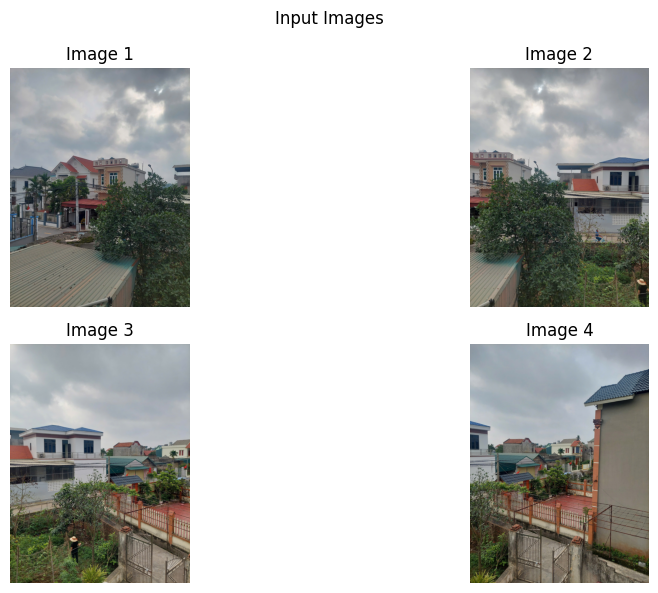

Image 1: Detected 3859 keypoints
Image 2: Detected 5217 keypoints
Image 3: Detected 5903 keypoints
Image 4: Detected 4821 keypoints


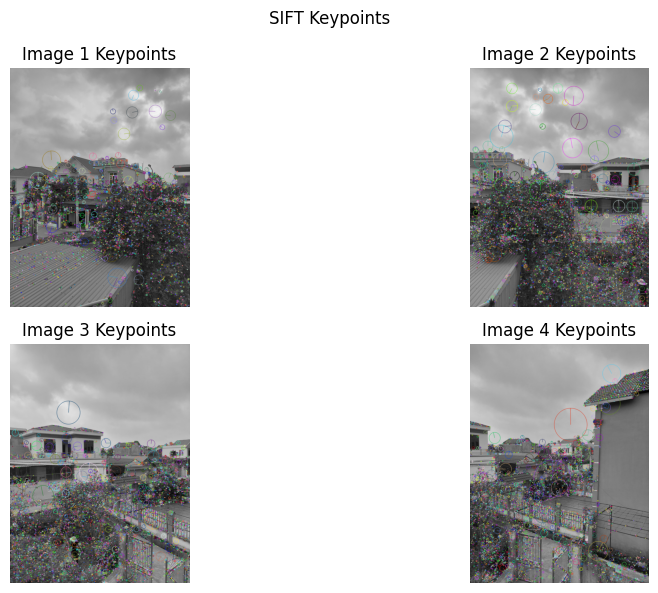

Image 1 to Image 2: 452 good matches
Image 2 to Image 3: 388 good matches
Image 3 to Image 4: 981 good matches


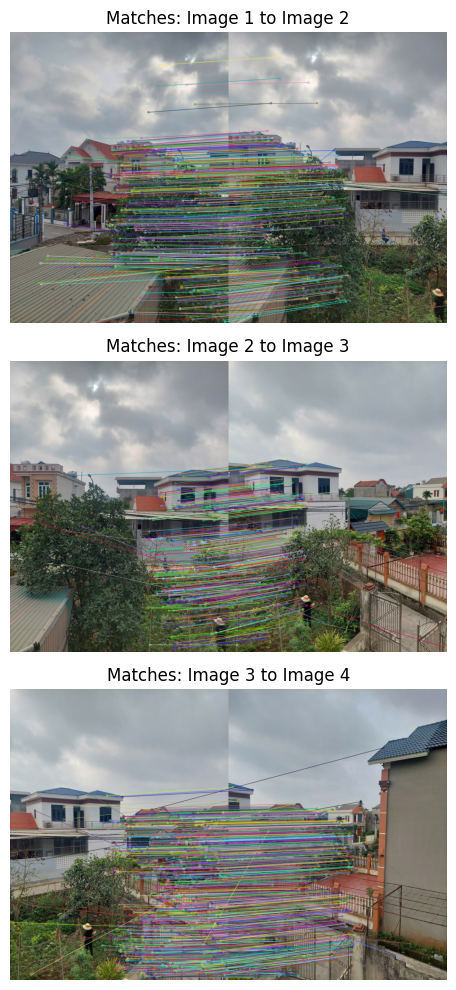

Image 1 to Image 2: 384 inliers out of 452 matches
Image 2 to Image 3: 300 inliers out of 388 matches
Image 3 to Image 4: 884 inliers out of 981 matches


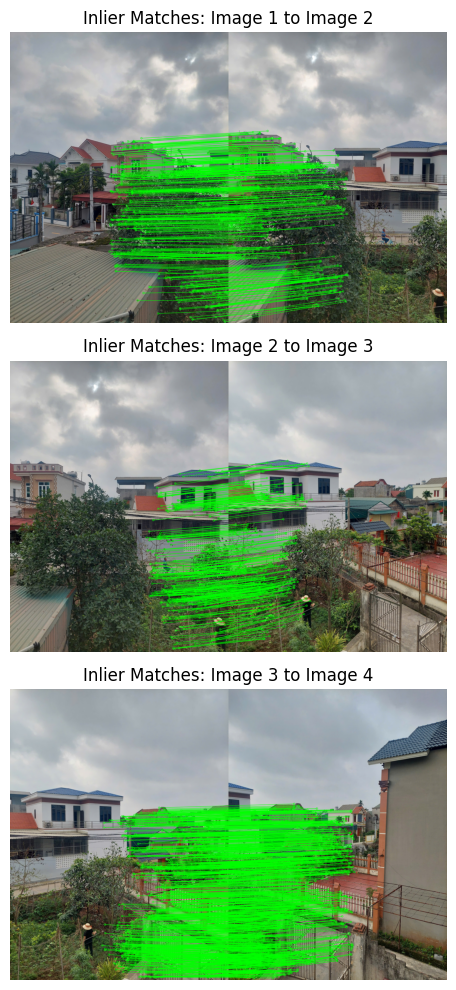

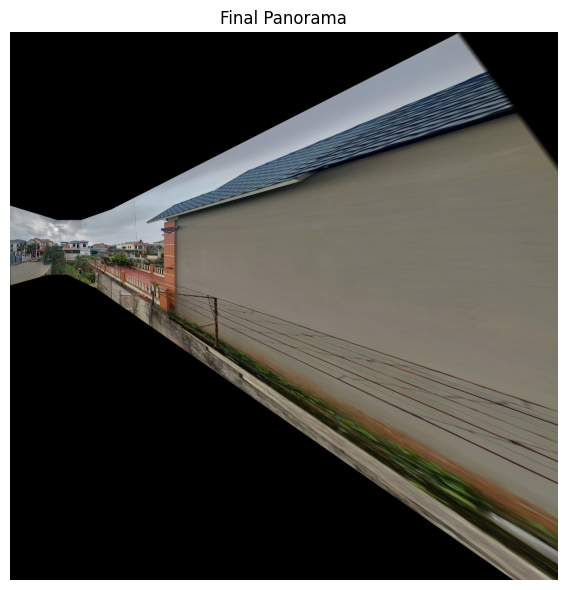

All outputs generated successfully. Check saved PNG files for report.


In [22]:
# Main execution
try:
    # Load and resize images
    images, gray_images = load_images(max_size=1000)
    
    # SIFT feature detection
    keypoints_list, descriptors_list = detect_sift_features(gray_images)
    
    # Feature matching
    matches_list = match_features(keypoints_list, descriptors_list)
    
    # Homography estimation
    homographies, inlier_masks = estimate_homography(keypoints_list, matches_list)
    
    # Warping and blending
    panorama = warp_and_blend_images(images, homographies)
    
    print("All outputs generated successfully. Check saved PNG files for report.")
except Exception as e:
    print(f"Error: {str(e)}")